# Annotating Cell Types

We will go over two ways we can annotate cell types automatically:
* **Known atlas**: In this case, we will use a cell type atlas with cell types that we expect to be in our dataset to annotate ours. We do this by mapping each of our cells to the cell types identified in the annotated set. 
The Seurat based Tutorial can be found [here](https://satijalab.org/seurat/articles/integration_mapping.html)

* **(Un)Known marker genes**: SC-Type uses marker genes that are either expected or not expected in certain cell types. You can provide your own set, but it has a database for the following tissues: Immune system, Pancreas, Liver, Eye, Kidney, Brain, Lung, Adrenal, Heart, Intestine, Muscle, Placenta, Spleen Stomach, Thymus.


In [26]:
library(Seurat)
library(ggplot2)
library(dplyr)
library(HGNChelper)
library(openxlsx)

## **Known Atlas**
Some great resources to find already defined atlases (good for references) include https://data.humancellatlas.org/, https://www.synapse.org/, and most importantly PubMed/google scholar. Most single-cell papers have a section with the finished data in the "Data Availability" or "Code Availability" section. These atlases will include the celltypes in the metadata. 
* *Note:* Sometimes, they are provided as AnnData objects rather than Seurat objects (.h5ad). These can be converted to Seurat objects via the function h5ad2seurat() from the package [schard](https://github.com/cellgeni/schard).

For demonstration purposes, we are using an object which contains half of the T21 dataset as the reference atlas to label the cell types for the other half of the T21 cells.

### 0. Get the data

In [31]:
# read in the appropriate Seurat object
load("./data/t21_official_umap_clust_06.25.24.Rdata")
# see what the names of the objects loaded are 
ls()

[1] "cell_state"          "cL_results_known"    "cL_results_test"    
 [4] "cl_type"             "db_"                 "es.max"             
 [7] "filt"                "gene_sets_prepare"   "gs_list"            
[10] "j"                   "known_color_values"  "ls_predictions"     
[13] "query_cells"         "ref_cells"           "scRNAseqData_scaled"
[16] "sctype_color_values" "sctype_score"        "sctype_scores_known"
[19] "sctype_scores_test"  "seurat_package_v5"   "ss_predictions"     
[22] "t21"                 "t21_query"           "t21_query.anchors"  
[25] "t21_ref"             "tissue"

In [32]:
# for each cell state, have half go to each
query_cells = c()
for (cell_state in unique(t21$cell.labels)) {
    # get the half the cells to keep
    filt = t21@meta.data[t21@meta.data$cell.labels == cell_state,]
    query_cells = c(query_cells, sample(rownames(filt), nrow(filt)/2), seed=42)
    }
length(query_cells)
ref_cells = setdiff(rownames(t21@meta.data), query_cells)
length(ref_cells)

[1] 8399

[1] 8382

In [33]:
# randomly split the data
t21_query <- subset(x = t21, cells = query_cells)
t21_ref <- subset(x = t21, cells = ref_cells)
dim(t21_query)
dim(t21_ref)
# we can now delete the original object
rm(t21)

[1] 33694  8361

[1] 33694  8382

### 1. Graph the original UMAP to see that the datasets are in fact split

This UMAP will look different from what you did yesterday because we are using only cells belonging to individuals with T21 for the variable genes, clustering and UMAP.

We show a graph with the Seurat clusters identified (when analyzing with all cells together)

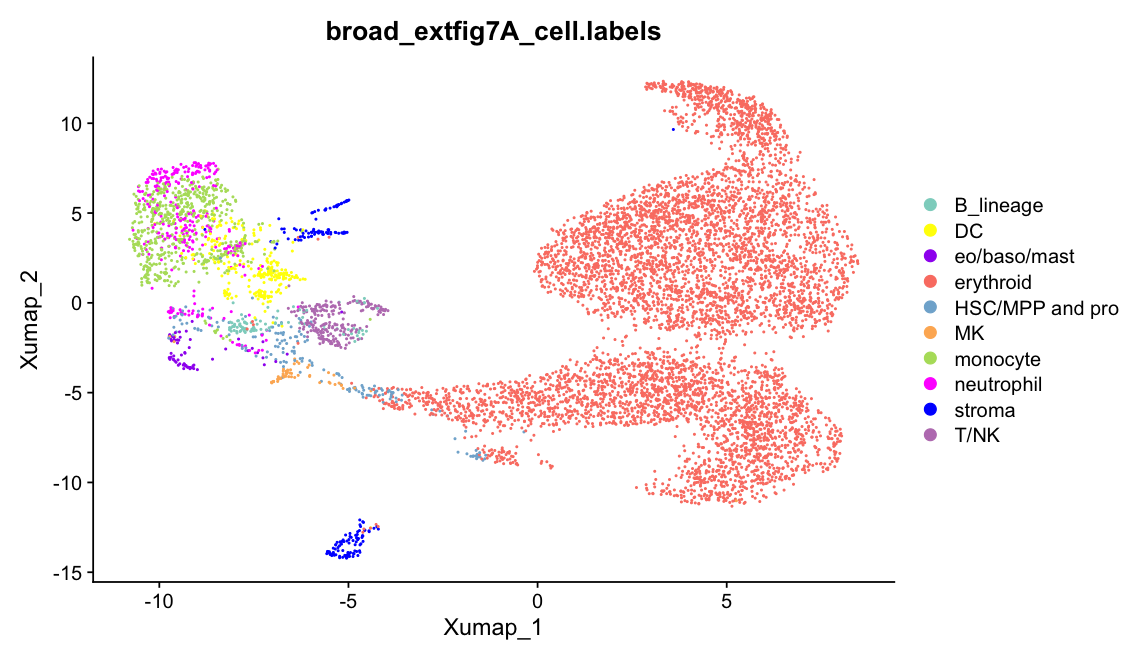

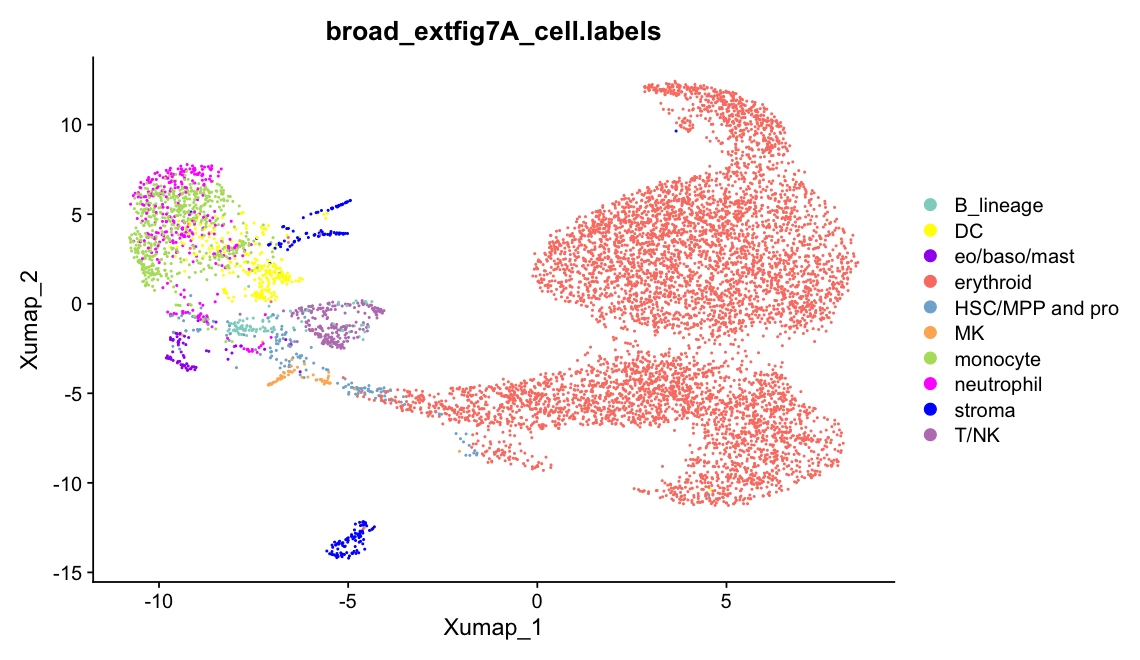

In [34]:
# having plootting dimensions make it easier to see
options(repr.plot.height=5.5, repr.plot.width=9.5)
# color coded the cell states for easier comparison
known_color_values = c("B_lineage"='#8DD3C7', 
                 "DC"='yellow', 
                 "eo/baso/mast"='purple', "erythroid"='#FB8072', "HSC/MPP and pro"='#80B1D3', 
                 "MK"='#FDB462', "monocyte"='#B3DE69', "neutrophil"='magenta', 
                 "stroma"='blue', "T/NK"='#BC80BD')

DimPlot(t21_query, group.by = c("broad_extfig7A_cell.labels"), reduction = 'Xumap_') + scale_color_manual(values=known_color_values)
DimPlot(t21_ref, group.by = c("broad_extfig7A_cell.labels"), reduction = 'Xumap_') + scale_color_manual(values=known_color_values)

### 2. Follow Seurat to transfer information

We are treating the t21_ref as our "reference" since we expect the same cell types to exist.
The Seurat based Tutorial can be found [here](https://satijalab.org/seurat/articles/integration_mapping.html)

1. Need to find anchors (FindTransferAnchors): pairs of cells from the reference and query datasets that are mutual nearest neighbors. This means that when you look at the dimension reductions of both, the cells are very similar to one another. Details found [here](https://satijalab.org/seurat/reference/findtransferanchors)
2. Transfer the reference data labels of interest to the query data (TransferData): This uses the anchors to help compare individual cells between one another annd transfer labels accordingly. Details found [here](https://satijalab.org/seurat/reference/transferdata)
3. Add the determined labels to the metadata of the query (AddMetaData)

In [35]:
# find anchors that allow transfer from the reference to the query object in Transfer data
# Details can be found here: https://satijalab.org/seurat/reference/findtransferanchors
t21_query.anchors <- FindTransferAnchors(reference = t21_ref, query = t21_query)

Performing PCA on the provided reference using 1607 features as input.

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 17463 anchors



In [36]:
# Classify the query cells based on the reference data
# Return = Matrix with predicted IDs and prediction scores
# Reference should be the cell type labels you want to follow
ls_predictions <- TransferData(anchorset = t21_query.anchors, 
                               refdata = t21_ref@meta.data$broad_extfig7A_cell.labels,)
ls_predictions[1:2,]
# double check the order of cells is the same (sanity check as they always should be)
identical(rownames(t21_query@meta.data), rownames(ls_predictions))
t21_query@meta.data$ls_predicted_id = ls_predictions$predicted.id
# add this predicted IDs and scores to the metadata of our query

t21_query@meta.data[1:2, c("ls_predicted_id", "broad_extfig7A_cell.labels", "cell.labels")]

Finding integration vectors

Finding integration vector weights

Predicting cell labels



,predicted.id,prediction.score.erythroid,prediction.score.B_lineage,prediction.score.monocyte,prediction.score.neutrophil,prediction.score.DC,prediction.score.HSC.MPP.and.pro,prediction.score.MK,prediction.score.stroma,prediction.score.eo.baso.mast,prediction.score.T.NK,prediction.score.max
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AAACGGGCACCGAAAG-1-DSOX4,monocyte,0,0,0.5798654,0.4201346,0,0,0,0,0,0,0.5798654
AAAGATGGTGTCAATC-1-DSOX4,stroma,0,0,0.0000000,0.0000000,0,0,0,1,0,0,1.0000000


[1] TRUE

,ls_predicted_id,broad_extfig7A_cell.labels,cell.labels
,<chr>,<chr>,<chr>
AAACGGGCACCGAAAG-1-DSOX4,monocyte,monocyte,promonocyte
AAAGATGGTGTCAATC-1-DSOX4,stroma,stroma,osteoblast


### 3. See how well this did
Since we have the truth set, we can see how well we did. We would expect almost perfect results given we're using half of the SAME dataset from which our query was derived. But do we get that?

In [38]:

# Count the # times where the predicted cell type matches the true one
t21_query$ls_prediction.match <- t21_query$ls_predicted_id == t21_query$broad_extfig7A_cell.labels
# See how many times it was equal (TRUE) vs not (FALSE)
table(t21_query$ls_prediction.match)


FALSE  TRUE 
  315  8046 

### D. Repeat this ON YOUR OWN but with the smaller scale cell labels
* *Hint*, the smaller scale cell types are under "cell.labels" in the t21 ref data
* Does this do better or worse than when we just try with the large scale cell types?

In [39]:

t21_query@meta.data[1:2, c("ls_predicted_id", "broad_extfig7A_cell.labels", "ss_predicted_id", "cell.labels")]

# Count the # times where the predicted cell type matches the true one
t21_query$ss_prediction.match <- t21_query$ss_predicted_id == t21_query$cell.labels
# See how many times it was equal (TRUE) vs not (FALSE)
table(t21_query$ls_prediction.match)
table(t21_query$ss_prediction.match)

ERROR: Error in `[.data.frame`(t21_query@meta.data, 1:2, c("ls_predicted_id", : undefined columns selected


## **(Un)Known Marker Genes**
SC-Type uses marker genes that are either expected or not expected in certain cell types. The full instructions on how to use it can be found at their [Github README](https://github.com/IanevskiAleksandr/sc-type). They also have an interactive [web implementation](https://sctype.app/) for it, but this can be more difficult to debug or use if you have really large files. Therefore, we will be showing the use here.


### 1. Load Functions and Database for SC-Type

In [40]:
# load gene set preparation function
source("https://raw.githubusercontent.com/IanevskiAleksandr/sc-type/master/R/gene_sets_prepare.R")
# load cell type annotation function
source("https://raw.githubusercontent.com/IanevskiAleksandr/sc-type/master/R/sctype_score_.R")

In [41]:
# Get the DB file
# name the tissue of interest
db_ <- "https://raw.githubusercontent.com/IanevskiAleksandr/sc-type/master/ScTypeDB_full.xlsx";
tissue <- "Immune system" 

# prepare gene sets
gs_list <- gene_sets_prepare(db_, tissue)


Warning message in checkGeneSymbols(markers_all):
“Human gene symbols should be all upper-case except for the 'orf' in open reading frames. The case of some letters was corrected.”
Warning message in checkGeneSymbols(markers_all):
“x contains non-approved gene symbols”
Warning message in checkGeneSymbols(markers_all):
“x contains non-approved gene symbols”
Warning message in checkGeneSymbols(markers_all):
“x contains non-approved gene symbols”
Warning message in checkGeneSymbols(markers_all):
“x contains non-approved gene symbols”
Warning message in checkGeneSymbols(markers_all):
“x contains non-approved gene symbols”
Warning message in checkGeneSymbols(markers_all):
“x contains non-approved gene symbols”
Warning message in checkGeneSymbols(markers_all):
“x contains non-approved gene symbols”
Warning message in checkGeneSymbols(markers_all):
“x contains non-approved gene symbols”
Warning message in checkGeneSymbols(markers_all):
“x contains non-approved gene symbols”
Warning message in

#### Now what cell types are considered in the default database? Do you think this will be detailed enough?

In [42]:
names(gs_list$gs_positive)
length(names(gs_list$gs_positive))

[1] "Pro-B cells"                                 
 [2] "Pre-B cells"                                 
 [3] "Naive B cells"                               
 [4] "Memory B cells"                              
 [5] "Plasma B cells"                              
 [6] "Naive CD8+ T cells"                          
 [7] "Naive CD4+ T cells"                          
 [8] "Memory CD8+ T cells"                         
 [9] "Memory CD4+ T cells"                         
[10] "Effector CD8+ T cells"                       
[11] "Effector CD4+ T cells"                       
[12] "γδ-T cells"                                  
[13] "Platelets"                                   
[14] "CD8+ NKT-like cells"                         
[15] "CD4+ NKT-like cells"                         
[16] "Natural killer  cells"                       
[17] "Eosinophils"                                 
[18] "Neutrophils"                                 
[19] "Basophils"                                   
[20] "Mast cells"                                  
[21] "Classical Monocytes"                         
[22] "Non-classical monocytes"                     
[23] "Intermediate monocytes"                      
[24] "Macrophages"                                 
[25] "Megakaryocyte"                               
[26] "Endothelial"                                 
[27] "Erythroid-like and erythroid precursor cells"
[28] "HSC/MPP cells"                               
[29] "Progenitor cells"                            
[30] "Myeloid Dendritic cells"                     
[31] "Plasmacytoid Dendritic cells"                
[32] "Granulocytes"                                
[33] "ISG expressing immune cells"                 
[34] "Cancer cells"

[1] 34

### 2. Have the SC data ready to analyze
* We want to use [["RNA"]] since that is where we havve the experiment information stored

In [43]:
# check Seurat object version (scRNA-seq matrix extracted differently in Seurat v4/v5)
seurat_package_v5 <- isFALSE('counts' %in% names(attributes(t21_query[["RNA"]])))

# extract scaled scRNA-seq matrix
scRNAseqData_scaled <- if (seurat_package_v5) as.matrix(t21_query[["RNA"]]$scale.data) else as.matrix(t21_query[["RNA"]]@scale.data)

### 3. Run ScType
* scaled=True: We are using Scaled data in our case
* gs = gs_positive -- the gene sets we expect to be in the cell types considering
* gs2 = gs_negative -- the gene sets we don't expect to be in the cell types considering

Running

In [44]:
# run ScType
es.max <- sctype_score(scRNAseqData = scRNAseqData_scaled, 
                       scaled = TRUE, gs = gs_list$gs_positive, 
                       gs2 = gs_list$gs_negative)
# This gets the scores for each cell regarding all the different possible cell types
dim(es.max)
es.max[1:3,1:4]

[1]   34 8361

,AAACGGGCACCGAAAG-1-DSOX4,AAAGATGGTGTCAATC-1-DSOX4,AAAGCAAGTACAGCAG-1-DSOX4,AAAGCAATCTTTAGTC-1-DSOX4
Pro-B cells,0.1670677,1.275089,-0.3819909,-0.6261402
Pre-B cells,0.4409616,3.193914,-0.4458718,-0.4458718
Naive B cells,0.1978080,2.026805,-0.5954000,-0.5954000


### 4. Based on single cell scores, assign the clusters with cell type annotations
* If we didn't know the cell types, we'd use seurat_clusters
* Since we do know the cell types, we can use broad_extfig7A_cell.labels which uses the large scale cell types

In [45]:
# Create the function to get the cell types according to sctype scoring
cL_results_known <- do.call("rbind", lapply(unique(t21_query@meta.data$broad_extfig7A_cell.labels), function(cl){
    # get the highest scoring cell type  for each of the clusters
    es.max.cl = sort(rowSums(es.max[ ,rownames(t21_query@meta.data[t21_query@meta.data$broad_extfig7A_cell.labels==cl, ])]), decreasing = !0)
    head(data.frame(cluster = cl, type = names(es.max.cl), scores = es.max.cl, ncells = sum(t21_query@meta.data$broad_extfig7A_cell.labels==cl)), 10)
}))

# run the function on each of the clusters, keeping the highest scoring one
sctype_scores_known <- cL_results_known %>% group_by(cluster) %>% top_n(n = 1, wt = scores)  

# optionally label those that are low confidence according to the ScType score and the number of cells (support)
# # set low-confident (low ScType score) clusters to "unknown"
sctype_scores_known$confidence <- "High"
sctype_scores_known$confidence[as.numeric(as.character(sctype_scores_known$scores)) < sctype_scores_known$ncells/4] <- "Low"

### 5. Look at results

In [46]:
# let's see how they matched up 
sctype_scores_known

cluster,type,scores,ncells,confidence
<chr>,<chr>,<dbl>,<int>,<chr>
monocyte,Classical Monocytes,2594.3348,568,High
stroma,Macrophages,617.9569,174,High
erythroid,Erythroid-like and erythroid precursor cells,132.5600,6457,Low
HSC/MPP and pro,Progenitor cells,410.3008,168,High
neutrophil,Neutrophils,1586.7922,310,High
B_lineage,Pro-B cells,1017.4910,93,High
MK,Megakaryocyte,416.5667,58,High
eo/baso/mast,Basophils,939.6480,64,High
T/NK,CD8+ NKT-like cells,2236.5478,217,High


#### Interpretation of results
Both DC and stroma were listed as Plasmacytoid dendritic cells.
HSC/MPP = multipotent progenitor. Although these types of cells are significantly different from basophils in function, they are close together in the UMAP, so it makes sense that it'd be difficult to distinguish for the tool.

In this case, we'd say that the stroma (145 cells) and HSC/MPP and pro (206 cells) were mislabeled. This gives us about 351 cells mislabeled compared to the 454 cells mislabeled with the Seurat integration mapping. Despite having no previous knowledge, this tool still did well.

In [47]:
known_color_values = c("B_lineage"='#8DD3C7', 
                 "DC"='yellow', 
                 "eo/baso/mast"='purple', "erythroid"='#FB8072', "HSC/MPP and pro"='#80B1D3', 
                 "MK"='#FDB462', "monocyte"='#B3DE69', "neutrophil"='magenta', 
                 "stroma"='blue', "T/NK"='#BC80BD')
sctype_color_values = c("Pro-B cells"='#8DD3C7', 
                 "Plasmacytoid Dendritic cells"='yellow', 
                 "Basophils"='purple', "Erythroid-like and erythroid precursor cells"='#FB8072', "Progenitor"='#80B1D3', 
                 "Megakaryocyte"='#FDB462', "Classical Monocytes"='#B3DE69', "Neutrophils"='magenta', 
                 "Macrophages"='blue', "CD8+ NKT-like cells"='#BC80BD')

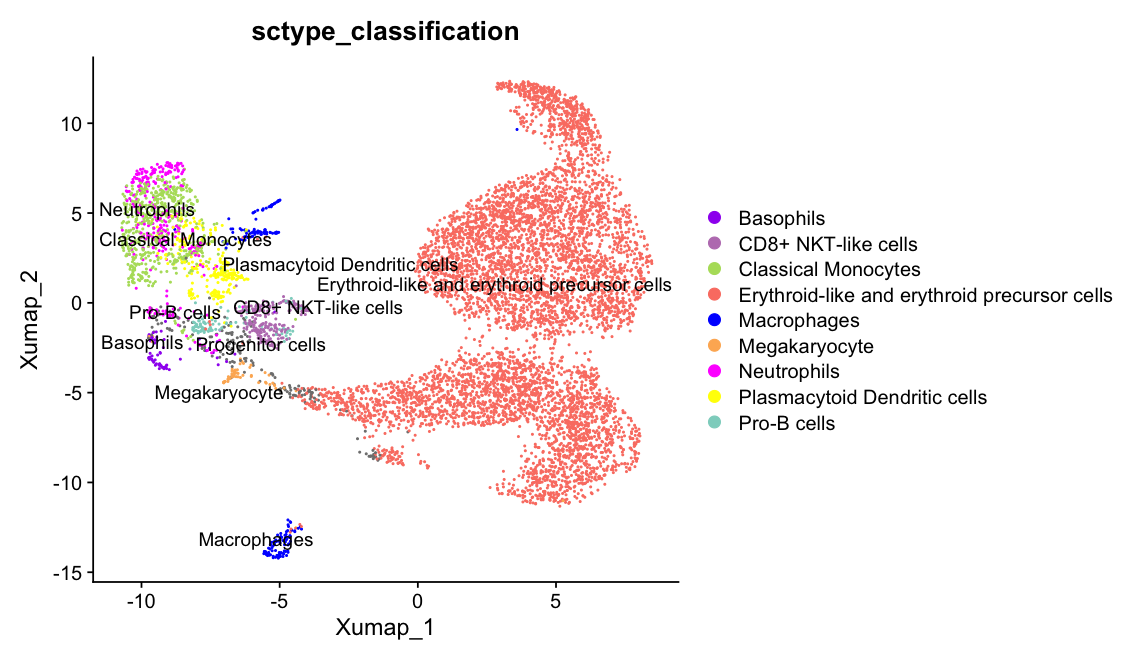

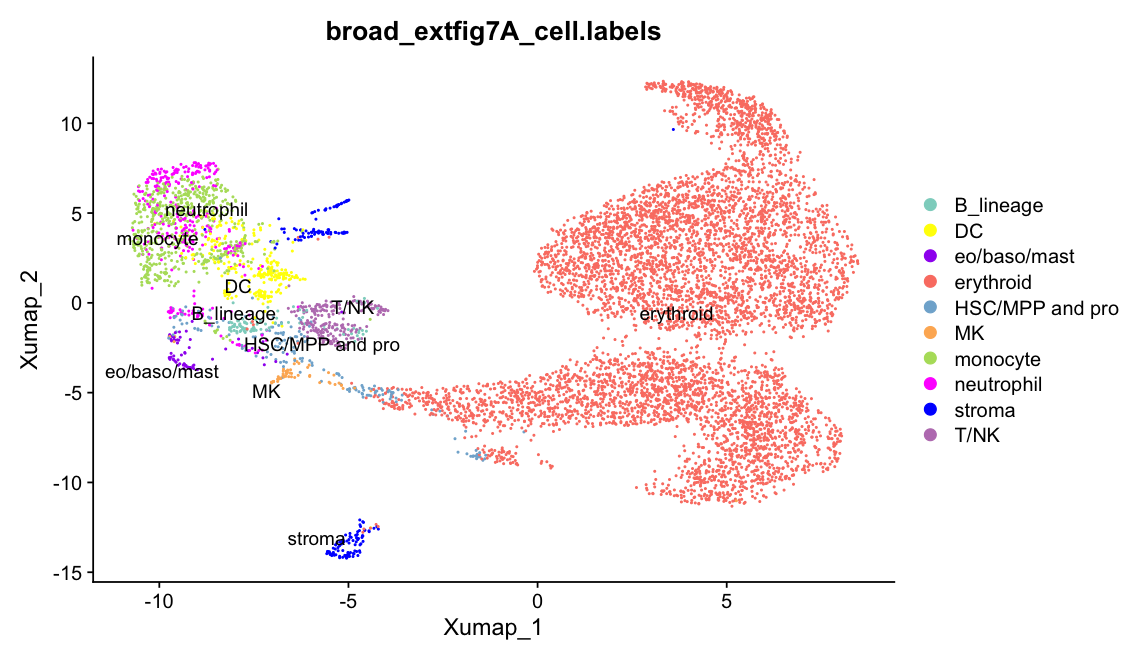

In [48]:
# adding the SCtype annotations
t21_query@meta.data$sctype_classification = ""
# for each of the ORIGINAL clusters
for(j in unique(sctype_scores_known$cluster)){
    # get the predicted cluster
  cl_type = sctype_scores_known[sctype_scores_known$cluster==j,]; 
  t21_query@meta.data$sctype_classification[t21_query@meta.data$broad_extfig7A_cell.labels == j] = as.character(cl_type$type[1])
}

# Graphing
DimPlot(t21_query, reduction = "Xumap_", label = TRUE, repel = TRUE, group.by = 'sctype_classification') + scale_color_manual(values=sctype_color_values)  
DimPlot(t21_query, reduction = "Xumap_", label = TRUE, repel = TRUE, group.by = 'broad_extfig7A_cell.labels') + scale_color_manual(values=known_color_values) 

## 6. Your turn with the smaller scale clusters
* Hint: the column name holding the known smaller scale clusters is in cell.labels

In [140]:
colnames(t21_query@meta.data)

[1] "orig.ident"                 "nCount_RNA"                
 [3] "nFeature_RNA"               "age"                       
 [5] "cell.labels"                "lanes"                     
 [7] "sequencing.type"            "sex"                       
 [9] "broad_extfig7A_cell.labels" "RNA_snn_res.0.6"           
[11] "seurat_clusters"            "ls_predicted_id"           
[13] "ls_prediction.match"        "ss_predicted_id"           
[15] "ss_prediction.match"        "sctype_classification"

In [ ]:
# Now you repeat the above with the seurat clusters instead
# HINT: use the seurat_clusters instead of broad_extfig7A_cell.labels

cL_results_test <- 

sctype_scores_test <- 

sctype_scores_test 

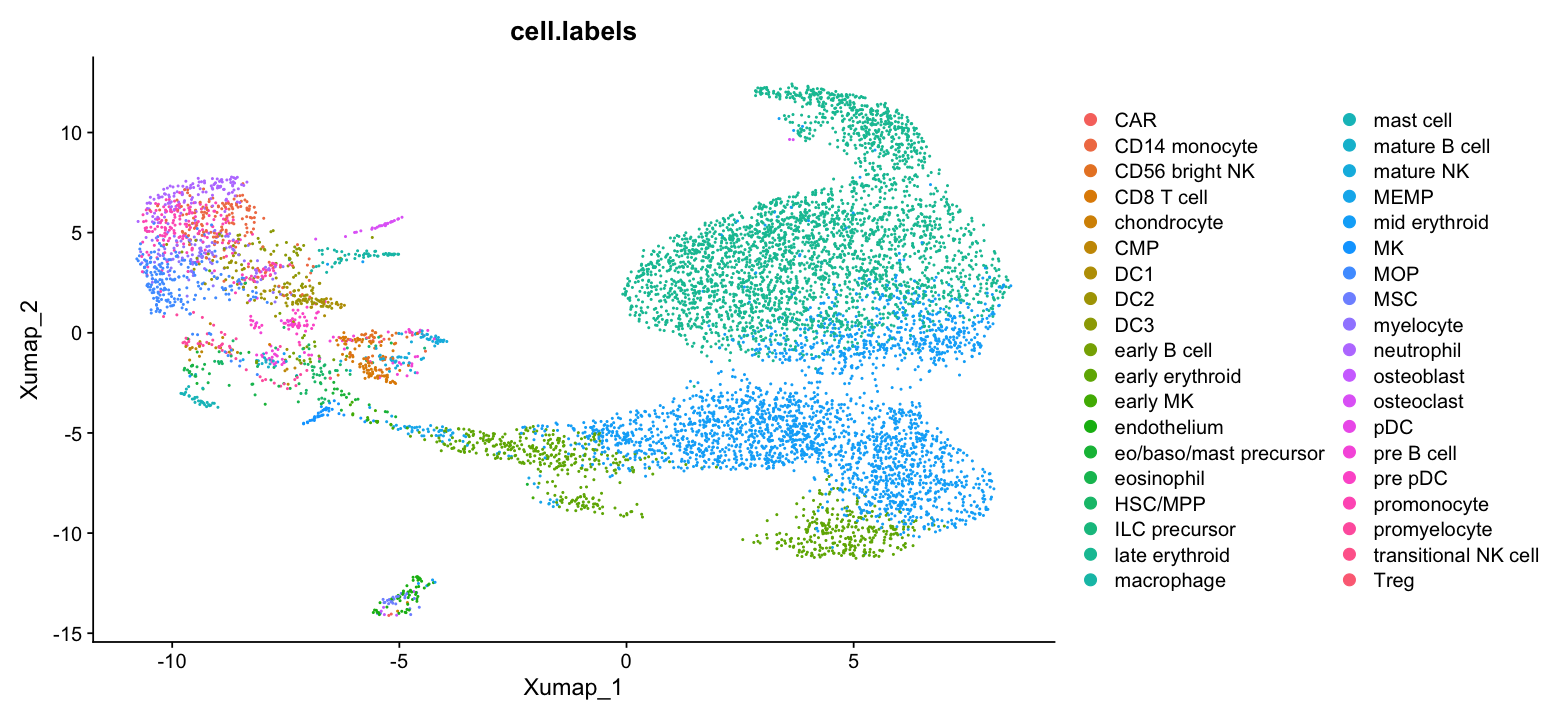

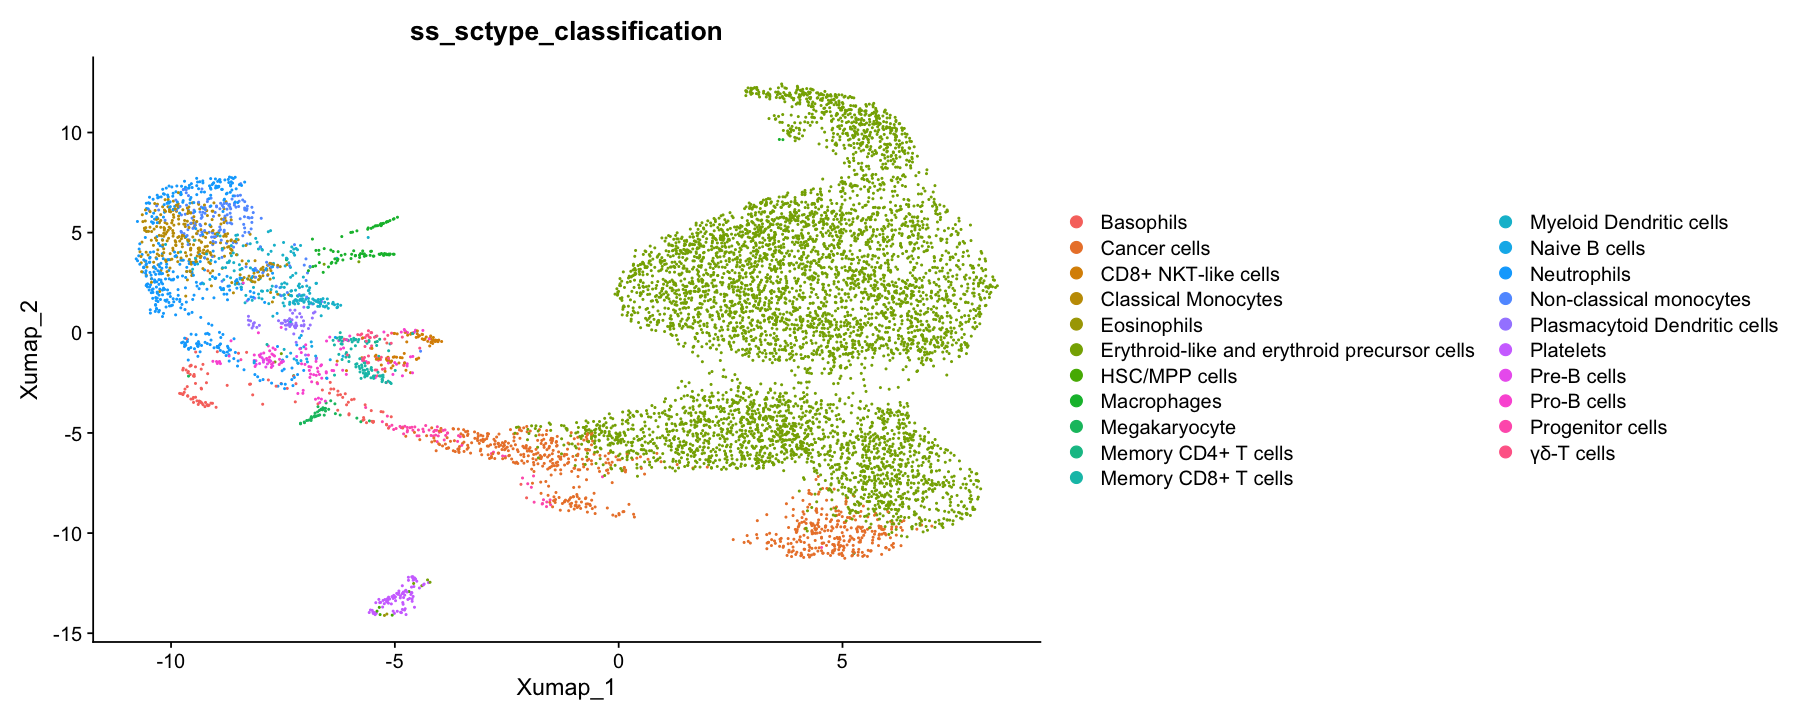

In [25]:
# adding the SCtype annotations to the metadata
t21_query@meta.data$ss_sctype_classification = ""
# for each of the ORIGINAL clusters
for(j in unique(sctype_scores_test$cluster)){
    # get the predicted cluster
  cl_type = sctype_scores_test[sctype_scores_test$cluster==j,]; 
  t21_query@meta.data$ss_sctype_classification[t21_query@meta.data$cell.labels == j] = as.character(cl_type$type[1])
}

# Graphing
options(repr.plot.height=6, repr.plot.width=13)
DimPlot(t21_query, reduction = "Xumap_", label = FALSE, repel = TRUE, group.by = 'cell.labels') 
options(repr.plot.height=6, repr.plot.width=15)
DimPlot(t21_query, reduction = "Xumap_", label = FALSE, repel = TRUE, group.by = 'ss_sctype_classification') 

### Now let's see what your results show
1. Was the default database used by this tool sensitive enough to distinguish between the cell states? (*Hint*: do we see a lot of the same cell type for different clusters?)
2. If yes, how might you be able to still use this tool but have a more sensitive database?

In [57]:
sctype_scores_test[order(sctype_scores_test$type),]

cluster,type,scores,ncells,confidence
<chr>,<chr>,<dbl>,<int>,<chr>
eo/baso/mast precursor,Basophils,121.124229,26,High
CMP,Basophils,104.568992,25,High
eosinophil,Basophils,443.580340,31,High
mast cell,Basophils,496.067694,33,High
early erythroid,Cancer cells,683.795784,674,High
mature NK,CD8+ NKT-like cells,1095.654934,73,High
CD56 bright NK,CD8+ NKT-like cells,442.161860,39,High
transitional NK cell,CD8+ NKT-like cells,75.115678,5,High
promonocyte,Classical Monocytes,1109.559579,197,High


## Answers
##
##
##
##
##
##







In [20]:
# haha nice try bud

Finding integration vectors

Finding integration vector weights

Predicting cell labels



[1] TRUE